# COVID-19 Regional Impact Assessment in California

The COVID-19 pandemic, caused by the SARS-CoV-2 virus, has had profound effects worldwide. The United States has been particularly impacted, with millions of cases and a high death toll, making it one of the hardest-hit countries globally. California, as the most populous state in the US, has faced significant challenges in managing the pandemic's spread and its economic and social consequences.

In this notebook, we will explore how different regions of California were affected, using various analytical and visualization tools. So let's start!

Firstly, I acquired my data from looking through the California Department of Public Health. I landed on [this](https://data.ca.gov/dataset/covid-19-hospital-data) dataset, which contained nearly thousands of entries of day to day logs of COVID-19 hospitalizations, grouped by the counties in California.

Importing necessary libraries, reading the csv.

In [1]:
import pandas as pd #cleaning, general manipulation of data
import matplotlib.pyplot as plt #creating visuals
import seaborn as sns
df = pd.read_csv("coviddata_csv.csv")

Let's take a look at the raw data, untouched.

In [2]:
df.head()

,county,todays_date,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds
0,Alameda,3/29/2020,36.0,91.0,NaN,NaN,20.0,16.0,119.0
1,Alameda,3/30/2020,59.0,94.0,NaN,NaN,27.0,18.0,160.0
2,Alameda,3/31/2020,56.0,89.0,NaN,NaN,27.0,17.0,63.0
3,Alameda,4/1/2020,52.0,76.0,NaN,NaN,27.0,15.0,106.0
4,Alameda,4/2/2020,57.0,76.0,NaN,NaN,29.0,17.0,112.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88589 entries, 0 to 88588
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   county                                 88589 non-null  object 
 1   todays_date                            88589 non-null  object 
 2   hospitalized_covid_confirmed_patients  88581 non-null  float64
 3   hospitalized_suspected_covid_patients  88580 non-null  float64
 4   hospitalized_covid_patients            87322 non-null  float64
 5   all_hospital_beds                      79957 non-null  float64
 6   icu_covid_confirmed_patients           88559 non-null  float64
 7   icu_suspected_covid_patients           63692 non-null  float64
 8   icu_available_beds                     87733 non-null  float64
dtypes: float64(7), object(2)
memory usage: 6.1+ MB


Our data is quite clean already, but let's get rid of those null values.

Because of the nature of the data, we cannot simply default null values to 0 (this would ruin our time series graphs). Therefore, we will simply drop rows with null values in important categories for analysis.

In [8]:
#drop our duplicate values
df.drop_duplicates(inplace=True)
#drop rows that have any null in them
df_dropped = df.dropna( inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61762 entries, 23 to 88231
Data columns (total 9 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   county                                 61762 non-null  object        
 1   todays_date                            61762 non-null  datetime64[ns]
 2   hospitalized_covid_confirmed_patients  61762 non-null  float64       
 3   hospitalized_suspected_covid_patients  61762 non-null  float64       
 4   hospitalized_covid_patients            61762 non-null  float64       
 5   all_hospital_beds                      61762 non-null  float64       
 6   icu_covid_confirmed_patients           61762 non-null  float64       
 7   icu_suspected_covid_patients           61762 non-null  float64       
 8   icu_available_beds                     61762 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 4.7+ MB


In [10]:
print(df.isnull().sum())

county                                   0
todays_date                              0
hospitalized_covid_confirmed_patients    0
hospitalized_suspected_covid_patients    0
hospitalized_covid_patients              0
all_hospital_beds                        0
icu_covid_confirmed_patients             0
icu_suspected_covid_patients             0
icu_available_beds                       0
dtype: int64


Let's start visualizing the data and see what we can find.

## Visualizing Our Data

To start with: our data is ideal for time series related visualizations. What we have is thousands of observations for 58 groups at equally spaced time intervals, over a span of 3 years.

Let's start with a simple line graph.

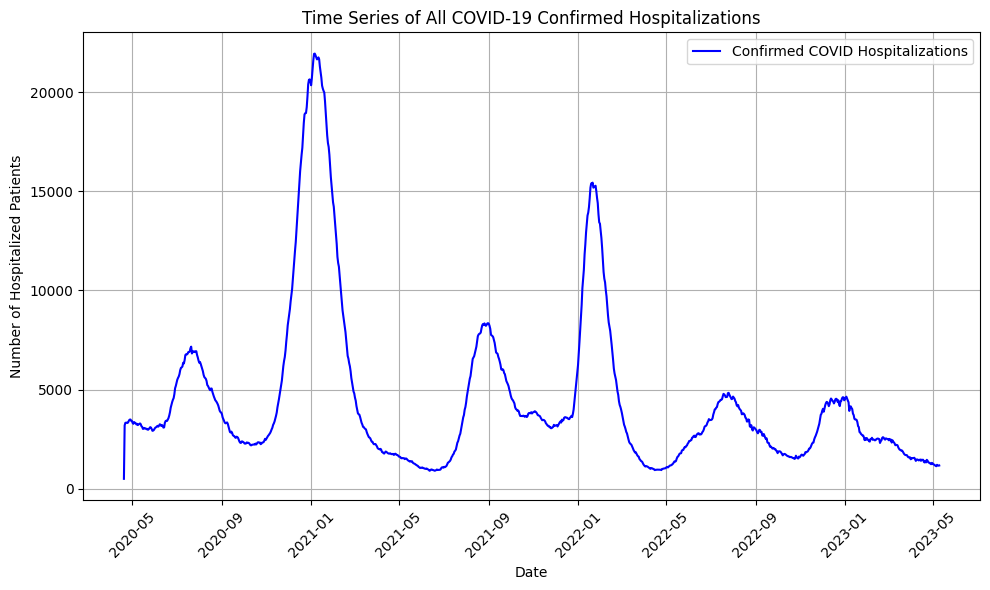

In [11]:
#reformatting, we're only going to make this datetime once
df['todays_date'] = pd.to_datetime(df['todays_date'], format='%m/%d/%Y')

# Aggregate data by date to sum the number of hospitalized confirmed patients across all counties
aggregated_data = df.groupby('todays_date')['hospitalized_covid_confirmed_patients'].sum().reset_index()

# Plotting the aggregated time series
plt.figure(figsize=(10,6))
plt.plot(aggregated_data['todays_date'], aggregated_data['hospitalized_covid_confirmed_patients'], label='Confirmed COVID Hospitalizations', color='b')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Number of Hospitalized Patients')
plt.title('Time Series of All COVID-19 Confirmed Hospitalizations')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

Here is a time series graph, showing the total number of confirmed hospitalizations over the course of the time period. This is all counties summed together.

This graph doesn't tell us all too much about regional data though. Let's chart a new time series graph with multiple lines. Each line will be a subregion of California; Northern California, the Bay Area, Southern California, the Central Valley, and the Central Coast.

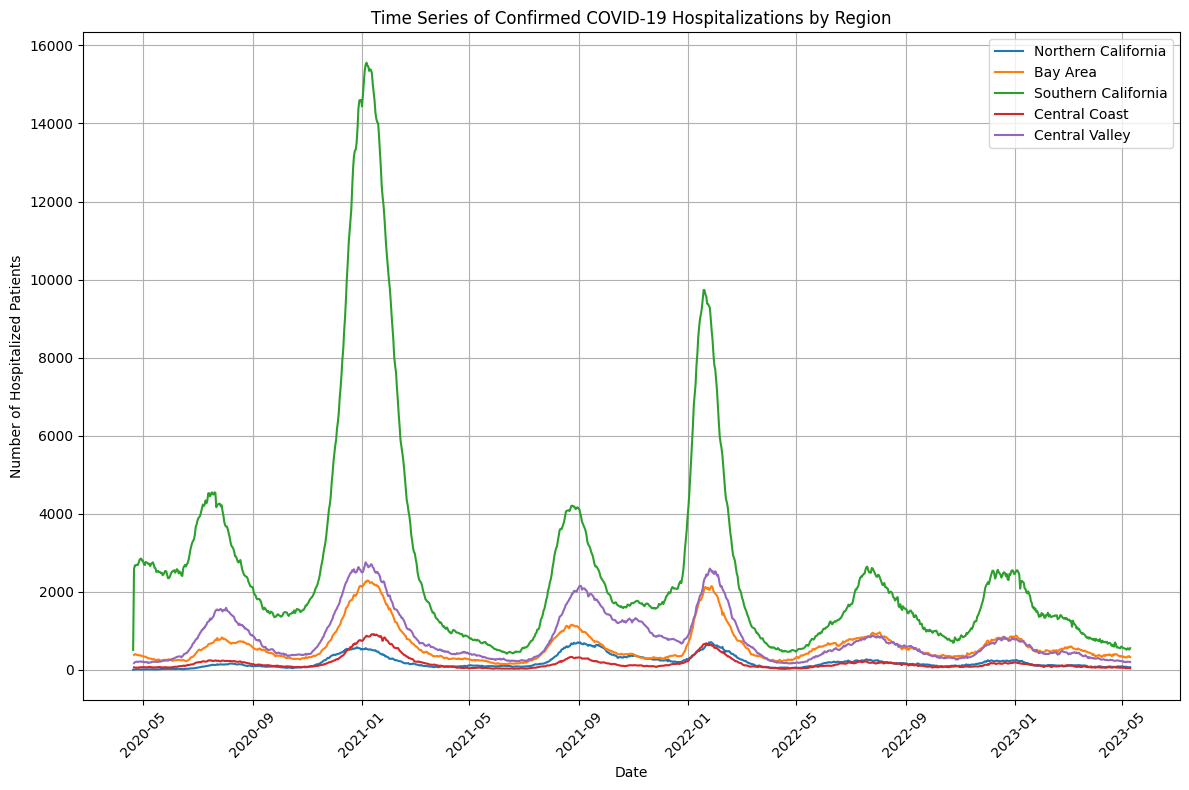

In [12]:
#Defined county regions
regions = {
    'Northern California': ['Del Norte', 'Siskiyou', 'Modoc', 'Humboldt', 'Trinity', 'Shasta', 'Lassen', 'Mendocino', 'Tehama', 'Plumas', 'Glenn', 'Butte', 'Sierra', 'Nevada', 'Yuba', 'Sutter', 'Colusa', 'Lake', 'Yolo', 'Placer', 'El Dorado'],
    'Bay Area': ['Sonoma', 'Marin', 'Napa', 'Solano', 'Contra Costa', 'Alameda', 'Santa Clara', 'San Mateo', 'San Francisco', 'Santa Cruz'],
    'Southern California': ['Los Angeles', 'Orange', 'San Diego', 'Riverside', 'San Bernardino', 'Imperial'],
    'Central Coast': ['Monterey', 'San Luis Obispo', 'Santa Barbara', 'Ventura'],
    'Central Valley': ['Sacramento','Amador', 'San Joaquin', 'Calaveras', 'Tuolumne', 'Mariposa', 'Madera', 'Fresno', 'Merced', 'Stanislaus', 'Kings', 'Tulare', 'Kern', 'Inyo', 'Mono']

}

# new dictionary for aggregated data
aggregated_regions = {}

# Group the data by region
for region, counties in regions.items():
    region_data = df[df['county'].isin(counties)]
    aggregated_region = region_data.groupby('todays_date')['hospitalized_covid_confirmed_patients'].sum().reset_index()
    aggregated_regions[region] = aggregated_region

# plotting each time series line for each region
plt.figure(figsize=(12,8))

for region, aggregated_data in aggregated_regions.items():
    plt.plot(aggregated_data['todays_date'], aggregated_data['hospitalized_covid_confirmed_patients'], label=region)


plt.xlabel('Date')
plt.ylabel('Number of Hospitalized Patients')
plt.title('Time Series of Confirmed COVID-19 Hospitalizations by Region')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


This map shows us how each of the regions compared with each other in confirmed COVID cases. We can see how dramatically greater Southern California's line is.

However, Southern California (which, for our definition, encompasses huge metropolitan areas like LA and SD) has a lot of people. Much more than any of our other regions.

So let's take the number of hospitalizations and express them as a percentage of each region's total populations in our next graph! I'll be using approximated population data acquired from the US Census Bureau.

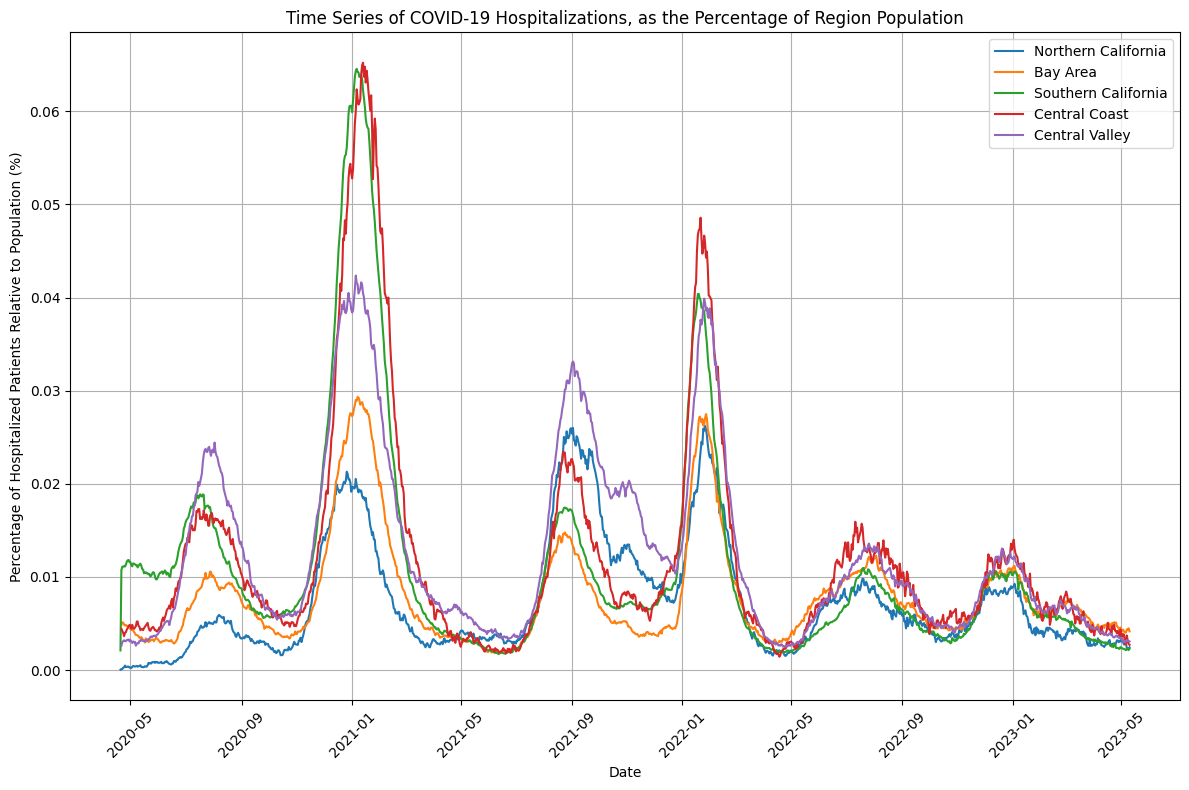

In [13]:
# approximated populations for each of our regions
region_populations = {
    'Northern California': 2_700_000,
    'Bay Area': 7_800_000,
    'Southern California': 24_100_000,
    'Central Coast': 1_400_000,
    'Central Valley': 6_500_000
}

# new dictionary
aggregated_regions = {}

# group by region
for region, counties in regions.items():
    region_data = df[df['county'].isin(counties)]
    aggregated_region = region_data.groupby('todays_date')['hospitalized_covid_confirmed_patients'].sum().reset_index()

    # Calculate the percentage of hospitalizations relative to population
    population = region_populations[region]  # Get the population for the region
    aggregated_region['percentage'] = (aggregated_region['hospitalized_covid_confirmed_patients'] / population) * 100  # Percentage

    aggregated_regions[region] = aggregated_region

# Plotting each time series line for each region as percentages
plt.figure(figsize=(12, 8))

for region, aggregated_data in aggregated_regions.items():
    # Plot the percentage
    plt.plot(aggregated_data['todays_date'], aggregated_data['percentage'], label=region)

plt.xlabel('Date')
plt.ylabel('Percentage of Hospitalized Patients Relative to Population (%)')
plt.title('Time Series of COVID-19 Hospitalizations, as the Percentage of Region Population')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Our new graph tells a distinctly new story about the COVID-19 timeline. The Central Coast region on the previous map seemed relatively tame in terms of the amount of COVID patients it hospitalized, but expressed as a percentage of its own population, we see that the Central Coast had, at one point, the highest percentage of hospitalized patients in California.

Let's try something else. Let's plot the aggregation of confirmed hospitalized COVID patients and the aggregation of suspected hospitalized COVID patients and see what the graph looks like.

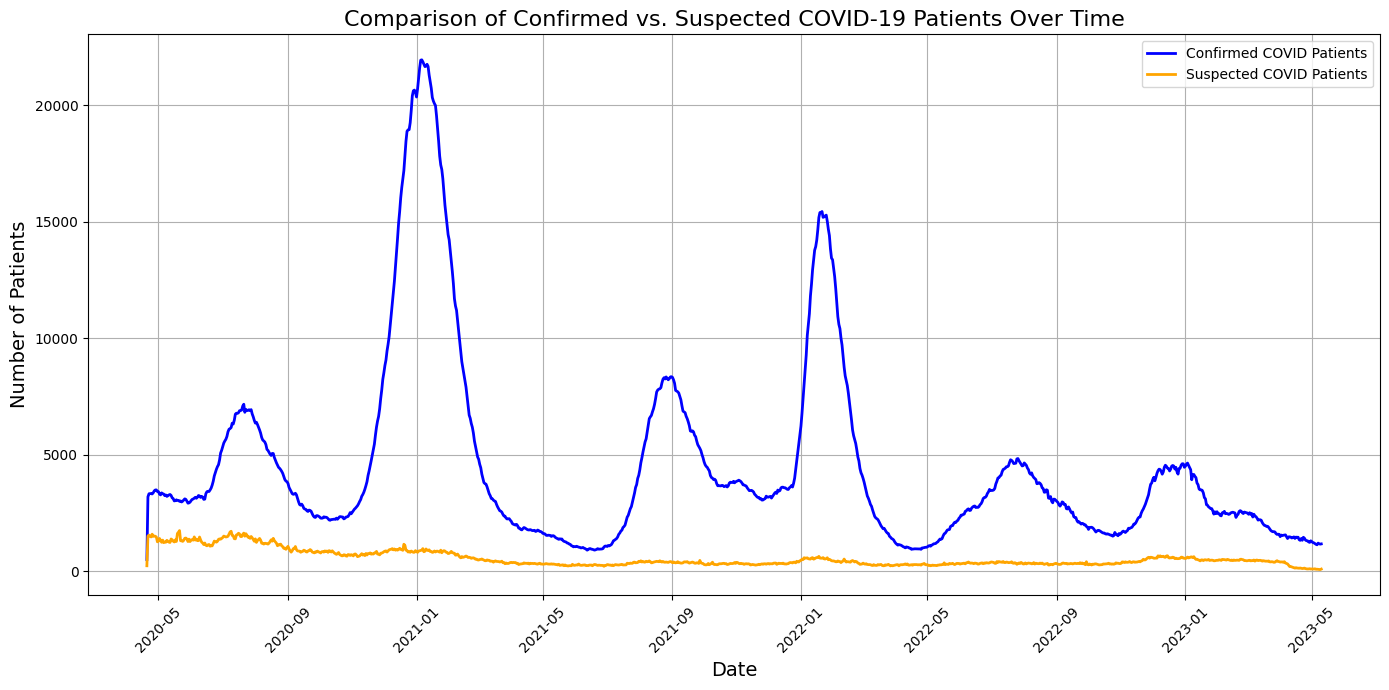

In [14]:
#Grouping by our two categories
aggregated_data = df.groupby('todays_date').agg({
    'hospitalized_covid_confirmed_patients': 'sum',
    'hospitalized_suspected_covid_patients': 'sum'
}).reset_index()

# Plotting our line
plt.figure(figsize=(14, 7))
plt.plot(aggregated_data['todays_date'], aggregated_data['hospitalized_covid_confirmed_patients'],
         label='Confirmed COVID Patients', color='blue', linewidth=2)
plt.plot(aggregated_data['todays_date'], aggregated_data['hospitalized_suspected_covid_patients'],
         label='Suspected COVID Patients', color='orange', linewidth=2)

# titles + labels
plt.title('Comparison of Confirmed vs. Suspected COVID-19 Patients Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.grid()


plt.tight_layout()
plt.show()

This is very interesting. You may have expected to see the two lines follow similar paths, which intuitively checks out; if there are more confirmed patients, maybe more people have it in general. However, we can see that through the whole graph, the suspected patients dwindle, and they remain relatively low all the way through the end.

This chart merely attempts to show an association between these two metrics, but there could be reasons as to why this is happening. Hospitals could have developed new testing methodologies that guaranteed accurate results better. Healthcare providers may have had an incentive to prioritize confirmed cases, leading to suspected individuals being less likely to go to hospitals. Unfortunately, we can only speculate as to what this reason may be given this dataset.

Finally, let's look at ICU Beds. Let's go ahead and go by region again, just the count of the available ICU Beds over time.

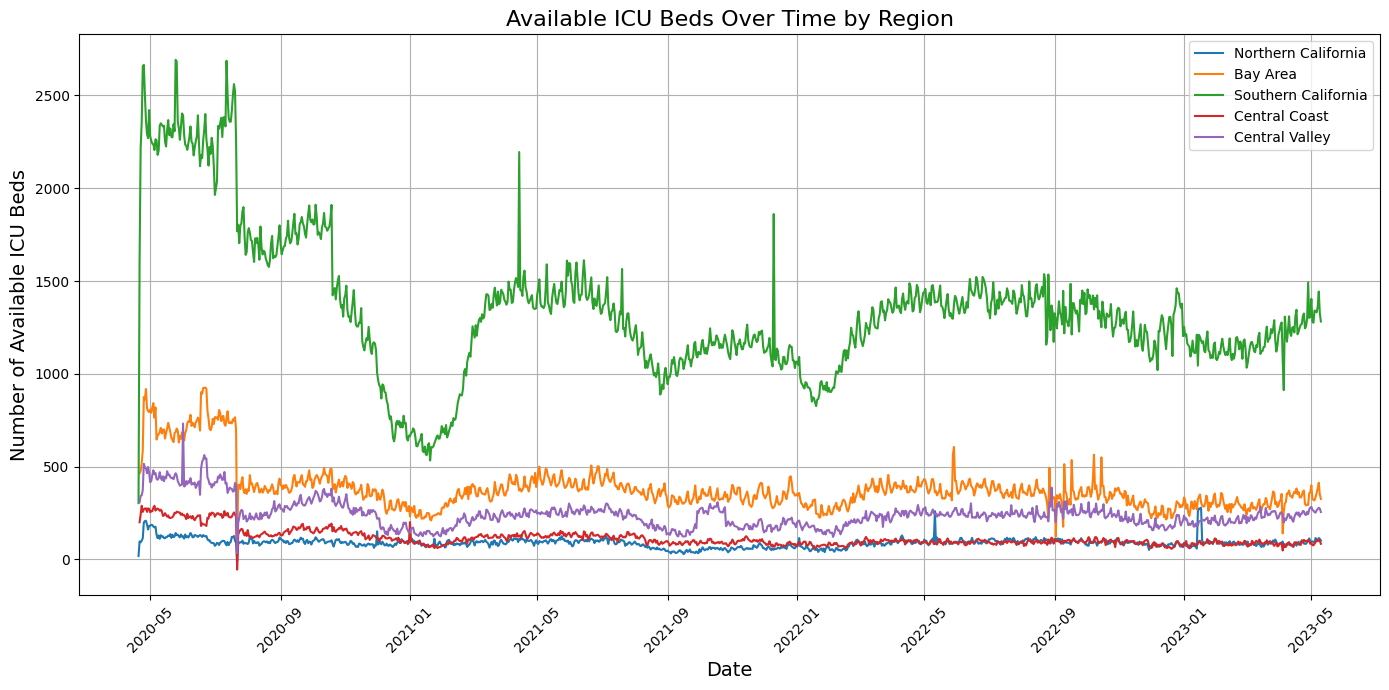

In [15]:
df['region'] = df['county'].apply(lambda x: next((region for region, counties in regions.items() if x in counties), None))

# Aggregate available ICU beds data by date and region
icu_beds_by_region = df.groupby(['todays_date', 'region'])['icu_available_beds'].sum().reset_index()

# Check if data is available for plotting
if icu_beds_by_region.empty:
    print("No data available for plotting.")
else:
    # Plotting the line chart
    plt.figure(figsize=(14, 7))

    # Plot each region
    for region in regions.keys():
        region_data = icu_beds_by_region[icu_beds_by_region['region'] == region]

        if not region_data.empty:
            plt.plot(region_data['todays_date'], region_data['icu_available_beds'],
                     label=region)

    # Chart formatting
    plt.title('Available ICU Beds Over Time by Region', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Number of Available ICU Beds', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

This data looks very funny. There are definitely external factors that influence this graph that don't involve COVID-19, and it's important to address them.

### Why are there random spikes, especially in the Southern California line?

It is here where we learn a possible flaw in how this data was being collected. This data comes directly from a governmental agency (CDPH), so the odds of this being a typo are low. What is more likely is the way this data was communicated from the hospitals to the government. These ICU beds were likely reported en masse. Due to some other factor; delayed reporting, available beds that cannot be operated with due to a staffing shortage, etc., beds reverted back to their pre-spike levels overnight. I think it's pretty important to highlight this, as it poses a problem in the game of telephone from hospital to government, and government to us as the data passes through multiple hands.

 This is why it is important to understand the scope of our visualization; our time series line graph shows us the amount of available ICU beds per region over time. There are millions of other variables out there that influence this ICU Bed count as well. The graph says nothing about the influence of COVID-19 directly, and it is incorrect to assume so. These ICU patients filling the beds could have any disease or illness and become a metric on this graph. It is very important to make this distinction.

## Insights

- Southern California had the greatest number of confirmed COVID-19 hospitalizations in one instance in California.
- The Central Coast (Santa Barbara, Ventura, etc.) held the greatest proportion of confirmed COVID-19 hospitalizations in one instance in California. It maintained this streak, remaining greater than all other regions during the Winter 2022 COVID-19 peak.
- The number of "suspected COVID-19 hospitalized patients" peaked towards the beginning of the pandemic, and dwindled into negligence over the time period. Some speculations include more advanced testing technologies (leading to less suspicion and more confirmation) and healthcare coverage prioritizing confirmed patients, although these are just speculations. The answer for this question is outside the scope of this dataset.
- We've identified a data communication problem between hospitals and the government. Further research and problem-solving remains to be done about the standardization of collecting this information for the purpose of analysis.